In [1]:
from pyspark.sql import SparkSession
from operator import add
import pandas as pd

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.250:7077") \
        .appName("anna_a3")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()
spark_context = spark_session.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/08 11:11:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import abs

def get_bpm_range(bpm_diff):
    if bpm_diff < 10:
        return 0.6
    elif bpm_diff < 20:
        return 0.4
    elif bpm_diff < 30:
        return 0.3
    elif bpm_diff < 40:
        return 0.1
    else:
        return 0.0

def get_loudness_range(loudness_diff):
    if loudness_diff < 2:
        return 0.4
    elif loudness_diff < 15:
        return 0.3
    elif loudness_diff < 35:
        return 0.2
    elif loudness_diff < 40:
        return 0.1
    else:
        return 0.0

get_bpm_range_udf = udf(get_bpm_range, FloatType())
get_loudness_range_udf = udf(get_loudness_range, FloatType())

def calculate_danceability(loudness_col, bpm_col):
    # Applying transformations to DataFrame columns
    loudness_col = abs(loudness_col + 7)
    bpm_col = abs(bpm_col - 120)
    
    # Apply UDFs to DataFrame columns
    loudness_score = get_loudness_range_udf(loudness_col)
    bpm_score = get_bpm_range_udf(bpm_col)
    
    # Calculate danceability
    danceability = bpm_score + loudness_score
    
    return danceability


# Define UDF for year_to_decade function
def year_to_decade_udf(year):
    return year - (year % 10)

year_to_decade_spark_udf = udf(year_to_decade_udf, IntegerType())

def prune_data(df):
    # Remove rows with missing values
    df = df.dropna()
    # Remove rows with invalid values
    df = df.filter((col('title') != '') & (col('year') > 0) & (col('year') < 2024) &
                   (col('bpm') > 0) & (col('bpm') < 300) &
                   (col('loudness') > -100) & (col('loudness') < 0))
    return df

def preprocess_data(df, check_year):
    # Calculate danceability
    new_df = prune_data(df)
    new_df = new_df.withColumn('danceability', calculate_danceability(col('loudness'), col('bpm')))
    # Prune the data
    if not check_year:
        new_df = new_df.drop('title')
    new_df = new_df.withColumn('decade', year_to_decade_spark_udf(col('year')))
    new_df = new_df.drop('loudness', 'bpm', 'year')
    return new_df

print('went ok :)')


went ok :)


Number of Rows: 10000
Number of Columns: 4
Number of Rows: 4667
Number of Columns: 3
+------+----+-----+
|decade|mean|count|
+------+----+-----+
|  1990|0.62| 1201|
|  1930|0.48|    6|
|  1950|0.58|   30|
|  1960|0.65|  137|
|  1970| 0.6|  246|
|  1920|0.63|    6|
|  1980|0.64|  437|
|  2000|0.63| 2536|
|  2010|0.66|   64|
|  1940|0.53|    4|
+------+----+-----+



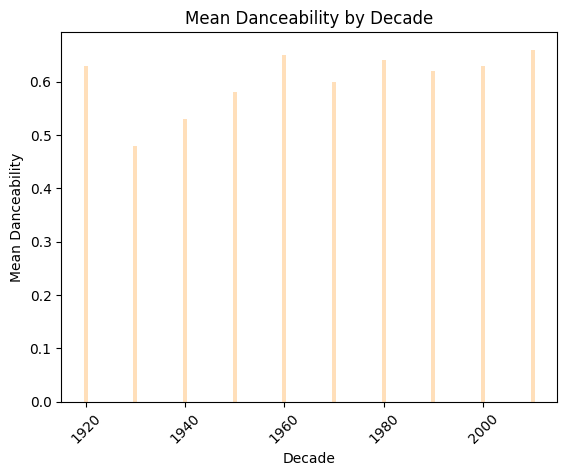

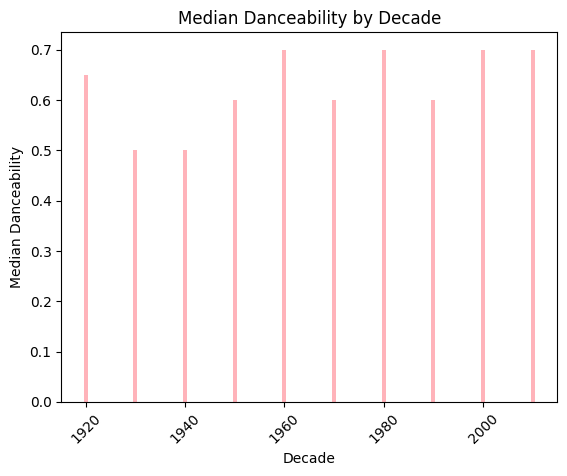

+--------------------+-----+
|rounded_danceability|count|
+--------------------+-----+
|                 0.0|    1|
|                 0.2|   47|
|                 0.3|  611|
|                 0.4|  794|
|                 0.5|  304|
|                 0.6|  574|
|                 0.7|  892|
|                 0.8|  399|
|                 0.9|  592|
|                 1.0|  453|
+--------------------+-----+



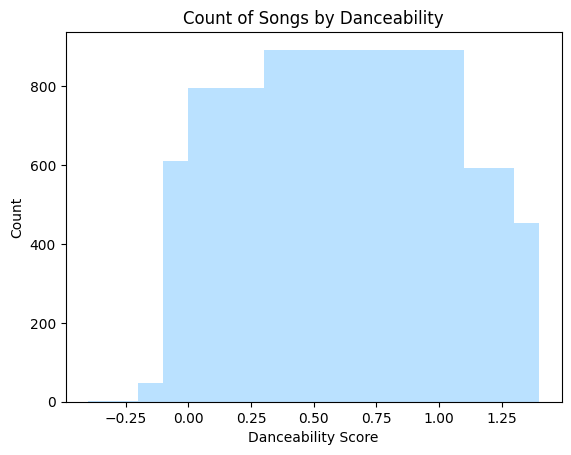

In [29]:
from pyspark.sql.functions import round
from pyspark.sql.functions import median

import matplotlib.pyplot as plt




file_path = "../data/aggregated_song_features.h5"
pandas_df = pd.read_hdf(file_path)

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark_session.createDataFrame(pandas_df)

num_rows = spark_df.count()

# Get the number of columns
num_columns = len(spark_df.columns)

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

preprocessed_df = preprocess_data(spark_df, check_year=True)

num_columns = len(preprocessed_df.columns)
num_rows = preprocessed_df.count()

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

grouped_decade = preprocessed_df.groupBy('decade')\
    .agg({'danceability': 'mean', '*': 'count'})\
    .withColumnRenamed('count(1)', 'count')\
    .withColumn('mean', round('avg(danceability)', 2))\
    .select('decade', 'mean', 'count')

# Show the result
grouped_decade.show()

#grouped_decade.write.csv('../data/mean_danceability_by_decade.csv', header=True) #became a folder? look up later


decades = grouped_decade.select('decade').rdd.flatMap(lambda x: x).collect()
mean_danceability = grouped_decade.select('mean').rdd.flatMap(lambda x: x).collect()

# Plotting
plt.bar(decades, mean_danceability, color='#ffdfba', linewidth=2.5)
plt.xticks(rotation=45)
plt.ylabel('Mean Danceability')
plt.xlabel('Decade')
plt.title('Mean Danceability by Decade')
plt.savefig('../images/mean_danceability_by_decade.png', bbox_inches='tight')
plt.show()


grouped_decade_median = preprocessed_df.groupBy('decade')\
    .agg({'danceability': 'median'})\
    .withColumnRenamed('median(danceability)', 'median_danceability')\
    .select('decade', 'median_danceability')\
    .withColumn('median_danceability', round('median_danceability', 2))

decades = grouped_decade_median.select('decade').rdd.flatMap(lambda x: x).collect()
median_danceability = grouped_decade_median.select('median_danceability').rdd.flatMap(lambda x: x).collect()

# Plotting
plt.bar(decades, median_danceability, color='#ffb3ba')
plt.xticks(rotation=45)
plt.ylabel('Median Danceability')
plt.xlabel('Decade')
plt.title('Median Danceability by Decade')
plt.savefig('../images/median_danceability_by_decade.png', bbox_inches='tight')
plt.show()


# Round danceability column to two decimal places
preprocessed_df_rounded = preprocessed_df.withColumn('rounded_danceability', round('danceability', 2))

# Group by rounded danceability scores and count the number of songs for each score
danceability_score_count = preprocessed_df_rounded.groupBy('rounded_danceability').count().orderBy('rounded_danceability')

# Show the result
danceability_score_count.show()

# Collect data to driver node
scores = danceability_score_count.select('rounded_danceability').rdd.flatMap(lambda x: x).collect()
counts = danceability_score_count.select('count').rdd.flatMap(lambda x: x).collect()

# Plotting
plt.bar(scores, counts, color='#bae1ff') #too thick!! Change later
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Danceability Score')
plt.title('Count of Songs by Danceability')
plt.savefig('../images/count_of_songs_by_danceability.png', bbox_inches='tight')
plt.show()